<a href="https://colab.research.google.com/github/MaCuur/AI_EGs/blob/main/Mapa_predicciones_y_por_estacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


def train_multivariate_with_coords(rain_file, coords_file, window_size=30, epochs=20, batch_size=32):
    """
    Entrena un LSTM multivariado para TODAS las estaciones e integra coordenadas.
    Guarda una gráfica PNG por cada estación y un mapa de predicciones.
    """

    # ---------------------------
    # 1. Load Data
    # ---------------------------
    df_rain = pd.read_csv(rain_file)
    df_rain = df_rain.interpolate(method="linear", limit_direction="forward", axis=0).fillna(0)
    data = df_rain.drop(columns=["Unnamed: 0"])
    stations = data.columns.tolist()

    # Cargar coordenadas
    df_coords = pd.read_csv(coords_file)
    coords_dict = df_coords.set_index("Clave")[["Lat", "Lon"]].T.to_dict()

    # ---------------------------
    # 2. Scale
    # ---------------------------
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data.values)

    # ---------------------------
    # 3. Create Sequences
    # ---------------------------
    X, y = [], []
    for i in range(len(data_scaled) - window_size):
        X.append(data_scaled[i:i+window_size])
        y.append(data_scaled[i+window_size])  # todas las estaciones

    X = np.array(X)
    y = np.array(y)

    # ---------------------------
    # 4. Split Train/Test
    # ---------------------------
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # ---------------------------
    # 5. Model
    # ---------------------------
    model = Sequential([
        LSTM(128, activation='tanh', return_sequences=False, input_shape=(window_size, X.shape[2])),
        Dense(X.shape[2])  # una salida por estación
    ])
    model.compile(optimizer='adam', loss='mse')
    model.summary()

    # ---------------------------
    # 6. Train
    # ---------------------------
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=1
    )

    # ---------------------------
    # 7. Predict
    # ---------------------------
    predictions = model.predict(X_test)
    predictions_rescaled = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test)

    # ---------------------------
    # 8. Save per-station plots
    # ---------------------------
    for idx, station in enumerate(stations):
        plt.figure(figsize=(12, 5))
        plt.plot(y_test_rescaled[:, idx], label=f"Actual {station}")
        plt.plot(predictions_rescaled[:, idx], label=f"Predicted {station}")
        plt.title(f"LSTM Forecast - Station: {station}")
        plt.legend()
        plt.xlabel("Days (Test Set)")
        plt.ylabel("Rainfall (mm)")
        output_file = f"{station}_forecast.png"
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"✅ Gráfica guardada: {output_file}")

    # ---------------------------
    # 9. Map visualization
    # ---------------------------
    # Tomamos el último valor predicho y observado por estación
    last_pred = predictions_rescaled[-1]
    last_real = y_test_rescaled[-1]

    plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-100, -98, 18.5, 20.5], crs=ccrs.PlateCarree())  # Ajusta a tu región
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES, linestyle=":")

    for idx, station in enumerate(stations):
        if station in coords_dict:
            lat, lon = coords_dict[station]["Lat"], coords_dict[station]["Lon"]
            ax.plot(lon, lat, "ko", markersize=5, transform=ccrs.PlateCarree())
            ax.text(lon+0.02, lat, station, fontsize=8, transform=ccrs.PlateCarree())
            # Mostramos valor predicho y real
            ax.text(lon+0.02, lat-0.05, f"P:{last_pred[idx]:.1f} / R:{last_real[idx]:.1f}",
                    fontsize=7, color="blue", transform=ccrs.PlateCarree())

    plt.title("Última predicción vs valor real por estación")
    plt.savefig("Mapa_predicciones.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("✅ Mapa guardado como Mapa_predicciones.png")

    return model, history


In [2]:
!pip install cartopy
import cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 77.0 MB/s eta 0:00:00


/tmp/ipython-input-1762722000.py:22: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_rain = df_rain.interpolate(method="linear", limit_direction="forward", axis=0).fillna(0)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       399,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 652)            │        84,108 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 483,980 (1.85 MB)

 Trainable params: 483,980 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 0.0162 - val_loss: 0.0108
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0062 - val_loss: 0.0072
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0055 - val_loss: 0.0066
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0054 - val_loss: 0.0060
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 0.0052 - val_loss: 0.0062
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0051 - val_loss: 0.0059
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0049 - val_loss: 0.0057
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0047 - val_loss: 0.0057
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


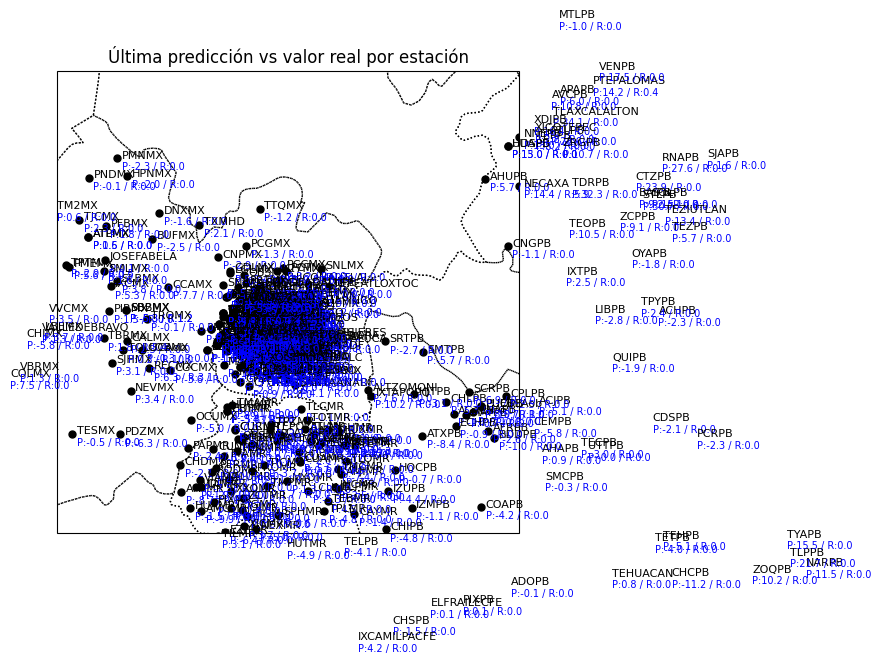

✅ Mapa guardado como Mapa_predicciones.png


In [4]:
model, history = train_multivariate_with_coords(
    rain_file="data/All_rain_Valle_bien.csv",
    coords_file="data/Posiciones_LL_SIH_Valle.csv",
    window_size=30,
    epochs=20,
    batch_size=32
)
